# Stochastic EM for ARHMM Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
# Set the parameters of the HMM
num_datas = 100    # number of data arrays
time_bins = 1000  # number of time bins per data array
num_states = 5    # number of discrete states
obs_dim = 2       # dimensionality of observation
lags = 1          # number of lags in the AR model

# Make an HMM
true_arhmm = ssm.HMM(num_states, obs_dim, 
                     observations="ar", 
                     observation_kwargs=dict(lags=lags))

# Sample data from the ARHMM

In [4]:
# Sample some data from the ARHMM
true_states, datas = list(zip(*[true_arhmm.sample(time_bins) for _ in range(num_datas)]))
true_lp = true_arhmm.log_probability(datas)

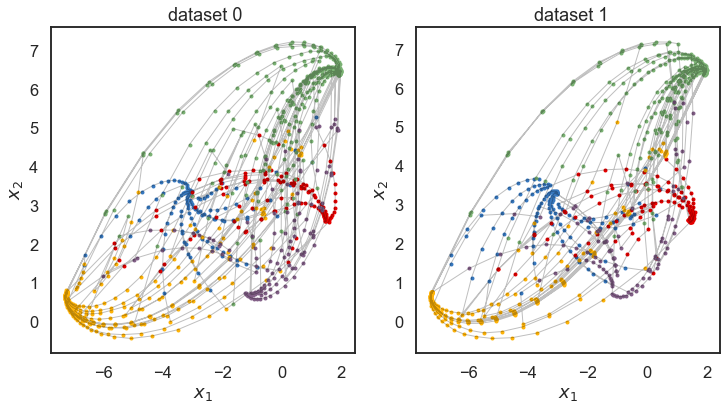

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for idx, ax in enumerate(axs):
    zs = true_states[idx]
    for k in range(num_states):
        ax.plot(datas[idx][true_states[idx]==k, 0], 
                datas[idx][true_states[idx]==k, 1], 
                'o', mfc=colors[k], mec='none', ms=4)

    ax.plot(datas[idx][:,0], datas[idx][:,1], '-k', lw=1, alpha=.25)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(" dataset " + str(idx % 2))

Below, we visualize each component of of the observation variable as a time series. The colors correspond to the latent state. The dotted lines represent the stationary point of the the corresponding AR state while the solid lines are the actual observations sampled from the HMM.

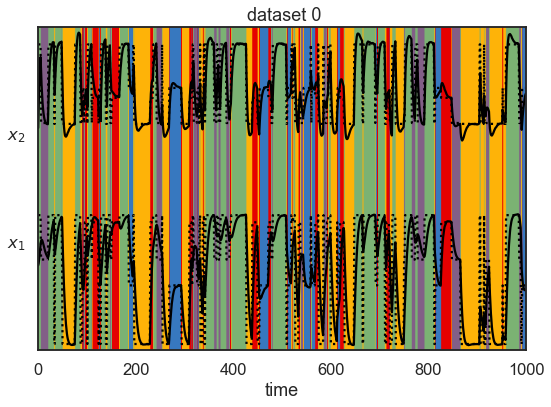

In [6]:
# Compute the stationary point for each AR model
assert lags == 1
idx = 0
As = true_arhmm.observations.As
bs = true_arhmm.observations.bs
mus = np.linalg.solve(np.eye(obs_dim) - As, bs)

# Plot the data and the smoothed data
lim = 1.05 * abs(datas[idx]).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_states[idx][None,:],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (obs_dim)*lim))


Ey = mus[true_states[idx]]
for d in range(obs_dim):
    plt.plot(datas[idx][:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(0, time_bins)
plt.xlabel("time")
plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

plt.title(" dataset " + str(idx % 2))

plt.tight_layout()


# Fit a regular ARHMM to all the data

In [10]:
model = ssm.HMM(num_states, obs_dim, 
                observations="ar",
                observation_kwargs=dict(lags=lags))

stochastic_em_lps, stochastic_em_inner_lps = \
    model.fit(datas,
              method="stochastic_em_conj", 
              num_epochs=10)


In [11]:
model = ssm.HMM(num_states, obs_dim, 
                observations="ar",
                observation_kwargs=dict(lags=lags))

em_lps= model.fit(datas,
                  method="em", 
                  num_iters=10)

Text(0.5, 1.0, 'Regular ARHMM Training Curves')

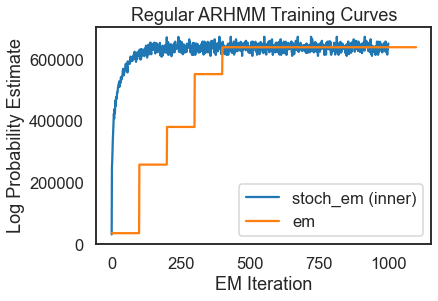

In [12]:
plt.plot(stochastic_em_inner_lps, label="stoch_em (inner)")
# plt.plot(np.repeat(stochastic_em_lps, num_datas), label="stoch_em")
plt.plot(np.repeat(em_lps, num_datas), label="em")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability Estimate")
plt.legend(loc="lower right")
plt.title("Regular ARHMM Training Curves")